# Data Augmentation

**Learning Objectives**

You will learn how to apply data augmentation in two ways:

1. How to use [Keras Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/).

2. How to load and preprocess images with `tf.image`.


## Introduction 
This notebook demonstrates data augmentation: a technique to increase the diversity of your training set by applying random (but realistic) transformations such as image rotation.

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/image_understanding/labs/data_augmentation.ipynb) -- try to complete that notebook first before reviewing this solution notebook.

In [ ]:
# Use the chown command to change the ownership of repository to user.
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

## Setup

In [2]:
!pip install -q tf-nightly

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


Please re-run the above cell if you are getting any incompatible warnings and errors.

In [3]:
# You can use any Python source file as a module by executing an import statement in some other Python source file.
# The import statement combines two operations; it searches for the named module, then it binds the results of that search
# to a name in the local scope.
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

This notebook uses TF2.x.
Please check your tensorflow version using the cell below.

In [ ]:
# Show the currently installed version of TensorFlow
print("TensorFlow version: ",tf.version.VERSION)

## Download a dataset

This tutorial uses the [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset. For convenience, download the dataset using [TensorFlow Datasets](https://www.tensorflow.org/datasets). If you would like to learn about others ways of importing data, see the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.


In [4]:
# Loads the named dataset into a `tf.data.Dataset`
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset tf_flowers downloaded and prepared to /home/kbuilder/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


The flowers dataset has five classes.

In [5]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


Let's retrieve an image from the dataset and use it to demonstrate data augmentation.

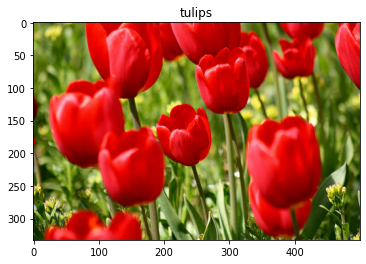

In [6]:
get_label_name = metadata.features['label'].int2str

# Display data as an image and set a title for the axes.
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Use Keras preprocessing layers

Note: The [Keras Preprocesing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) introduced in this section are currently experimental.

### Resizing and rescaling


You can use preprocessing layers to [resize](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) your images to a consistent shape, and to [rescale](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) pixel values.

In [7]:
IMG_SIZE = 180

# Sequential groups a linear stack of layers into a tf.keras.Model.
resize_and_rescale = tf.keras.Sequential([
# TODO
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

Note: the rescaling layer above standardizes pixel values to `[0,1]`. If instead you wanted `[-1,1]`, you would write `Rescaling(1./127.5, offset=-1)`.


You can see the result of applying these layers to an image. 

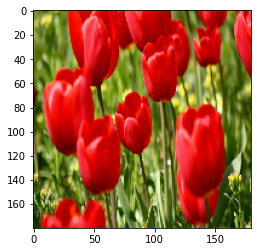

In [8]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

You can verify the pixels are in `[0-1]`.

In [9]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### Data augmentation

You can use preprocessing layers for data augmentation as well.

Let's create a few preprocessing layers and apply them repeatedly to the same image.

In [10]:
# Sequential groups a linear stack of layers into a tf.keras.Model.
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

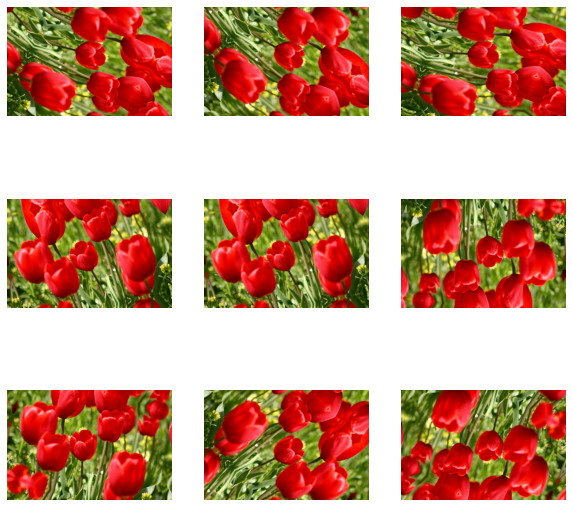

In [12]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
# Add a subplot to the current figure.
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

There are a variety of preprocessing [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) you can use for data augmentation including `layers.RandomContrast`, `layers.RandomCrop`, `layers.RandomZoom`, and others.

### Two options to use the preprocessing layers

There are two ways you can use these preprocessing layers, with important tradeoffs.

#### Option 1: Make the preprocessing layers part of your model

In [13]:
model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model
])

There are two important points to be aware of in this case:

* Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.

* When you export your model using `model.save`, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

Note: Data augmentation is inactive at test time so input images will only be augmented during calls to `model.fit` (not `model.evaluate` or `model.predict`).

#### Option 2: Apply the preprocessing layers to your dataset

In [14]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

With this approach, you use `Dataset.map` to create a dataset that yields batches of augmented images. In this case:

* Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using `Dataset.prefetch`, shown below.
* In this case the prepreprocessing layers will not be exported with the model when you call `model.save`. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.


You can find an example of the first option in the [image classification](https://www.tensorflow.org/tutorials/images/classification) tutorial. Let's demonstrate the second option here.

### Apply the preprocessing layers to the datasets

Configure the train, validation, and test datasets with the preprocessing layers you created above. You will also configure the datasets for performance, using parallel reads and buffered prefetching to yield batches from disk without I/O become blocking. You can learn more dataset performance in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide. 

Note: data augmentation should only be applied to the training set.

In [15]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
# TODO
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### Train a model

For completeness, you will now train a model using these datasets. This model has not been tuned for accuracy (the goal is to show you the mechanics).

In [17]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
# Config the model with losses and metrics with model.compile()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# Train the model with model.fit()
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


 1/92 [..............................] - ETA: 2:25 - loss: 1.6117 - accuracy: 0.1875

 2/92 [..............................] - ETA: 33s - loss: 1.8312 - accuracy: 0.1875 

 3/92 [..............................] - ETA: 30s - loss: 1.8920 - accuracy: 0.1875

 4/92 [>.............................] - ETA: 29s - loss: 1.9055 - accuracy: 0.1934

 5/92 [>.............................] - ETA: 29s - loss: 1.9097 - accuracy: 0.1997

 6/92 [>.............................] - ETA: 28s - loss: 1.9045 - accuracy: 0.2037

 7/92 [=>............................] - ETA: 28s - loss: 1.8947 - accuracy: 0.2097

 8/92 [=>............................] - ETA: 28s - loss: 1.8833 - accuracy: 0.2143

 9/92 [=>............................] - ETA: 28s - loss: 1.8717 - accuracy: 0.2171

10/92 [==>...........................] - ETA: 27s - loss: 1.8603 - accuracy: 0.2188

11/92 [==>...........................] - ETA: 27s - loss: 1.8494 - accuracy: 0.2214

12/92 [==>...........................] - ETA: 26s - loss: 1.8391 - accuracy: 0.2235

13/92 [===>..........................] - ETA: 26s - loss: 1.8295 - accuracy: 0.2250

14/92 [===>..........................] - ETA: 25s - loss: 1.8205 - accuracy: 0.2263

15/92 [===>..........................] - ETA: 25s - loss: 1.8121 - accuracy: 0.2276

16/92 [====>.........................] - ETA: 25s - loss: 1.8042 - accuracy: 0.2296

17/92 [====>.........................] - ETA: 24s - loss: 1.7967 - accuracy: 0.2320

18/92 [====>.........................] - ETA: 24s - loss: 1.7895 - accuracy: 0.2338

19/92 [=====>........................] - ETA: 23s - loss: 1.7827 - accuracy: 0.2357

20/92 [=====>........................] - ETA: 23s - loss: 1.7759 - accuracy: 0.2377

21/92 [=====>........................] - ETA: 23s - loss: 1.7693 - accuracy: 0.2396

22/92 [======>.......................] - ETA: 22s - loss: 1.7630 - accuracy: 0.2415

23/92 [======>.......................] - ETA: 22s - loss: 1.7569 - accuracy: 0.2433

24/92 [======>.......................] - ETA: 21s - loss: 1.7512 - accuracy: 0.2450

25/92 [=======>......................] - ETA: 21s - loss: 1.7455 - accuracy: 0.2467

26/92 [=======>......................] - ETA: 21s - loss: 1.7400 - accuracy: 0.2483

27/92 [=======>......................] - ETA: 20s - loss: 1.7346 - accuracy: 0.2499

28/92 [========>.....................] - ETA: 20s - loss: 1.7294 - accuracy: 0.2515

29/92 [========>.....................] - ETA: 20s - loss: 1.7241 - accuracy: 0.2534

30/92 [========>.....................] - ETA: 19s - loss: 1.7190 - accuracy: 0.2551

31/92 [=========>....................] - ETA: 19s - loss: 1.7140 - accuracy: 0.2567

32/92 [=========>....................] - ETA: 19s - loss: 1.7091 - accuracy: 0.2583

33/92 [=========>....................] - ETA: 18s - loss: 1.7042 - accuracy: 0.2600

34/92 [==========>...................] - ETA: 18s - loss: 1.6992 - accuracy: 0.2618

35/92 [==========>...................] - ETA: 18s - loss: 1.6940 - accuracy: 0.2637

36/92 [==========>...................] - ETA: 17s - loss: 1.6888 - accuracy: 0.2658

37/92 [===========>..................] - ETA: 17s - loss: 1.6838 - accuracy: 0.2677

38/92 [===========>..................] - ETA: 17s - loss: 1.6790 - accuracy: 0.2696

39/92 [===========>..................] - ETA: 16s - loss: 1.6743 - accuracy: 0.2715

40/92 [============>.................] - ETA: 16s - loss: 1.6697 - accuracy: 0.2733

41/92 [============>.................] - ETA: 16s - loss: 1.6651 - accuracy: 0.2752

42/92 [============>.................] - ETA: 15s - loss: 1.6606 - accuracy: 0.2770

43/92 [=============>................] - ETA: 15s - loss: 1.6561 - accuracy: 0.2789

44/92 [=============>................] - ETA: 15s - loss: 1.6519 - accuracy: 0.2807

45/92 [=============>................] - ETA: 14s - loss: 1.6478 - accuracy: 0.2824

46/92 [==============>...............] - ETA: 14s - loss: 1.6438 - accuracy: 0.2840

47/92 [==============>...............] - ETA: 14s - loss: 1.6399 - accuracy: 0.2857

48/92 [==============>...............] - ETA: 13s - loss: 1.6361 - accuracy: 0.2872

49/92 [==============>...............] - ETA: 13s - loss: 1.6324 - accuracy: 0.2887

50/92 [===============>..............] - ETA: 13s - loss: 1.6288 - accuracy: 0.2902

51/92 [===============>..............] - ETA: 12s - loss: 1.6252 - accuracy: 0.2917

52/92 [===============>..............] - ETA: 12s - loss: 1.6216 - accuracy: 0.2931

53/92 [================>.............] - ETA: 12s - loss: 1.6182 - accuracy: 0.2945

54/92 [================>.............] - ETA: 11s - loss: 1.6147 - accuracy: 0.2960

55/92 [================>.............] - ETA: 11s - loss: 1.6113 - accuracy: 0.2974

56/92 [=================>............] - ETA: 11s - loss: 1.6079 - accuracy: 0.2988

57/92 [=================>............] - ETA: 10s - loss: 1.6047 - accuracy: 0.3002

58/92 [=================>............] - ETA: 10s - loss: 1.6014 - accuracy: 0.3015

59/92 [==================>...........] - ETA: 10s - loss: 1.5982 - accuracy: 0.3029

60/92 [==================>...........] - ETA: 9s - loss: 1.5950 - accuracy: 0.3042 

61/92 [==================>...........] - ETA: 9s - loss: 1.5920 - accuracy: 0.3055

62/92 [===================>..........] - ETA: 9s - loss: 1.5889 - accuracy: 0.3068

63/92 [===================>..........] - ETA: 8s - loss: 1.5858 - accuracy: 0.3082

64/92 [===================>..........] - ETA: 8s - loss: 1.5827 - accuracy: 0.3095

65/92 [====================>.........] - ETA: 8s - loss: 1.5797 - accuracy: 0.3107

66/92 [====================>.........] - ETA: 8s - loss: 1.5768 - accuracy: 0.3120

67/92 [====================>.........] - ETA: 7s - loss: 1.5739 - accuracy: 0.3133

68/92 [=====================>........] - ETA: 7s - loss: 1.5710 - accuracy: 0.3145

69/92 [=====================>........] - ETA: 7s - loss: 1.5682 - accuracy: 0.3158

70/92 [=====================>........] - ETA: 6s - loss: 1.5654 - accuracy: 0.3170

71/92 [======================>.......] - ETA: 6s - loss: 1.5626 - accuracy: 0.3183

72/92 [======================>.......] - ETA: 6s - loss: 1.5599 - accuracy: 0.3195

73/92 [======================>.......] - ETA: 5s - loss: 1.5573 - accuracy: 0.3207

74/92 [=======================>......] - ETA: 5s - loss: 1.5546 - accuracy: 0.3218

75/92 [=======================>......] - ETA: 5s - loss: 1.5520 - accuracy: 0.3230

76/92 [=======================>......] - ETA: 4s - loss: 1.5494 - accuracy: 0.3242

77/92 [========================>.....] - ETA: 4s - loss: 1.5467 - accuracy: 0.3254

78/92 [========================>.....] - ETA: 4s - loss: 1.5441 - accuracy: 0.3265

79/92 [========================>.....] - ETA: 3s - loss: 1.5416 - accuracy: 0.3276

80/92 [=========================>....] - ETA: 3s - loss: 1.5390 - accuracy: 0.3287

81/92 [=========================>....] - ETA: 3s - loss: 1.5365 - accuracy: 0.3298

82/92 [=========================>....] - ETA: 3s - loss: 1.5340 - accuracy: 0.3310

83/92 [==========================>...] - ETA: 2s - loss: 1.5315 - accuracy: 0.3321

84/92 [==========================>...] - ETA: 2s - loss: 1.5290 - accuracy: 0.3332

85/92 [==========================>...] - ETA: 2s - loss: 1.5265 - accuracy: 0.3343

86/92 [===========================>..] - ETA: 1s - loss: 1.5241 - accuracy: 0.3354

87/92 [===========================>..] - ETA: 1s - loss: 1.5217 - accuracy: 0.3365

88/92 [===========================>..] - ETA: 1s - loss: 1.5193 - accuracy: 0.3376

89/92 [============================>.] - ETA: 0s - loss: 1.5170 - accuracy: 0.3386

90/92 [============================>.] - ETA: 0s - loss: 1.5146 - accuracy: 0.3397

91/92 [============================>.] - ETA: 0s - loss: 1.5123 - accuracy: 0.3407

92/92 [==============================] - ETA: 0s - loss: 1.5101 - accuracy: 0.3418

92/92 [==============================] - 30s 315ms/step - loss: 1.5078 - accuracy: 0.3428 - val_loss: 1.0809 - val_accuracy: 0.6240


Epoch 2/5


 1/92 [..............................] - ETA: 1:02 - loss: 1.0820 - accuracy: 0.5938

 2/92 [..............................] - ETA: 26s - loss: 1.0756 - accuracy: 0.5781 

 3/92 [..............................] - ETA: 26s - loss: 1.0980 - accuracy: 0.5590

 4/92 [>.............................] - ETA: 26s - loss: 1.0996 - accuracy: 0.5540

 5/92 [>.............................] - ETA: 26s - loss: 1.0978 - accuracy: 0.5520

 6/92 [>.............................] - ETA: 26s - loss: 1.0963 - accuracy: 0.5529

 7/92 [=>............................] - ETA: 25s - loss: 1.0966 - accuracy: 0.5511

 8/92 [=>............................] - ETA: 25s - loss: 1.0999 - accuracy: 0.5496

 9/92 [=>............................] - ETA: 25s - loss: 1.1009 - accuracy: 0.5494

10/92 [==>...........................] - ETA: 24s - loss: 1.1027 - accuracy: 0.5495

11/92 [==>...........................] - ETA: 24s - loss: 1.1025 - accuracy: 0.5502

12/92 [==>...........................] - ETA: 24s - loss: 1.1024 - accuracy: 0.5508

13/92 [===>..........................] - ETA: 23s - loss: 1.1019 - accuracy: 0.5515

14/92 [===>..........................] - ETA: 23s - loss: 1.1018 - accuracy: 0.5518

15/92 [===>..........................] - ETA: 23s - loss: 1.1016 - accuracy: 0.5522

16/92 [====>.........................] - ETA: 22s - loss: 1.1009 - accuracy: 0.5527

17/92 [====>.........................] - ETA: 22s - loss: 1.1006 - accuracy: 0.5527

18/92 [====>.........................] - ETA: 22s - loss: 1.1007 - accuracy: 0.5526

19/92 [=====>........................] - ETA: 21s - loss: 1.1006 - accuracy: 0.5530

20/92 [=====>........................] - ETA: 21s - loss: 1.1006 - accuracy: 0.5531

21/92 [=====>........................] - ETA: 21s - loss: 1.1010 - accuracy: 0.5532

22/92 [======>.......................] - ETA: 20s - loss: 1.1012 - accuracy: 0.5534

23/92 [======>.......................] - ETA: 20s - loss: 1.1015 - accuracy: 0.5536

24/92 [======>.......................] - ETA: 20s - loss: 1.1017 - accuracy: 0.5536

25/92 [=======>......................] - ETA: 20s - loss: 1.1017 - accuracy: 0.5538

26/92 [=======>......................] - ETA: 19s - loss: 1.1015 - accuracy: 0.5541

27/92 [=======>......................] - ETA: 19s - loss: 1.1011 - accuracy: 0.5545

28/92 [========>.....................] - ETA: 19s - loss: 1.1007 - accuracy: 0.5549

29/92 [========>.....................] - ETA: 18s - loss: 1.1004 - accuracy: 0.5552

30/92 [========>.....................] - ETA: 18s - loss: 1.1000 - accuracy: 0.5557

31/92 [=========>....................] - ETA: 18s - loss: 1.0994 - accuracy: 0.5562

32/92 [=========>....................] - ETA: 17s - loss: 1.0988 - accuracy: 0.5568

33/92 [=========>....................] - ETA: 17s - loss: 1.0981 - accuracy: 0.5573

34/92 [==========>...................] - ETA: 17s - loss: 1.0974 - accuracy: 0.5578

35/92 [==========>...................] - ETA: 16s - loss: 1.0970 - accuracy: 0.5583

36/92 [==========>...................] - ETA: 16s - loss: 1.0966 - accuracy: 0.5588

37/92 [===========>..................] - ETA: 16s - loss: 1.0963 - accuracy: 0.5591

38/92 [===========>..................] - ETA: 15s - loss: 1.0963 - accuracy: 0.5594

39/92 [===========>..................] - ETA: 15s - loss: 1.0961 - accuracy: 0.5597

40/92 [============>.................] - ETA: 15s - loss: 1.0961 - accuracy: 0.5601

41/92 [============>.................] - ETA: 15s - loss: 1.0959 - accuracy: 0.5605

42/92 [============>.................] - ETA: 14s - loss: 1.0957 - accuracy: 0.5609

43/92 [=============>................] - ETA: 14s - loss: 1.0954 - accuracy: 0.5614

44/92 [=============>................] - ETA: 14s - loss: 1.0950 - accuracy: 0.5619

45/92 [=============>................] - ETA: 13s - loss: 1.0945 - accuracy: 0.5623

46/92 [==============>...............] - ETA: 13s - loss: 1.0942 - accuracy: 0.5627

47/92 [==============>...............] - ETA: 13s - loss: 1.0938 - accuracy: 0.5632

48/92 [==============>...............] - ETA: 13s - loss: 1.0934 - accuracy: 0.5636

49/92 [==============>...............] - ETA: 12s - loss: 1.0930 - accuracy: 0.5639

50/92 [===============>..............] - ETA: 12s - loss: 1.0925 - accuracy: 0.5642

51/92 [===============>..............] - ETA: 12s - loss: 1.0922 - accuracy: 0.5646

52/92 [===============>..............] - ETA: 11s - loss: 1.0917 - accuracy: 0.5649

53/92 [================>.............] - ETA: 11s - loss: 1.0912 - accuracy: 0.5653

54/92 [================>.............] - ETA: 11s - loss: 1.0906 - accuracy: 0.5656

55/92 [================>.............] - ETA: 10s - loss: 1.0901 - accuracy: 0.5660

56/92 [=================>............] - ETA: 10s - loss: 1.0897 - accuracy: 0.5663

57/92 [=================>............] - ETA: 10s - loss: 1.0893 - accuracy: 0.5666

58/92 [=================>............] - ETA: 10s - loss: 1.0890 - accuracy: 0.5668

59/92 [==================>...........] - ETA: 9s - loss: 1.0888 - accuracy: 0.5670 

60/92 [==================>...........] - ETA: 9s - loss: 1.0885 - accuracy: 0.5672

61/92 [==================>...........] - ETA: 9s - loss: 1.0881 - accuracy: 0.5674

62/92 [===================>..........] - ETA: 8s - loss: 1.0877 - accuracy: 0.5677

63/92 [===================>..........] - ETA: 8s - loss: 1.0873 - accuracy: 0.5679

64/92 [===================>..........] - ETA: 8s - loss: 1.0870 - accuracy: 0.5681

65/92 [====================>.........] - ETA: 8s - loss: 1.0866 - accuracy: 0.5683

66/92 [====================>.........] - ETA: 7s - loss: 1.0863 - accuracy: 0.5685

67/92 [====================>.........] - ETA: 7s - loss: 1.0859 - accuracy: 0.5687

68/92 [=====================>........] - ETA: 7s - loss: 1.0855 - accuracy: 0.5690

69/92 [=====================>........] - ETA: 6s - loss: 1.0851 - accuracy: 0.5692

70/92 [=====================>........] - ETA: 6s - loss: 1.0848 - accuracy: 0.5694

71/92 [======================>.......] - ETA: 6s - loss: 1.0844 - accuracy: 0.5696

72/92 [======================>.......] - ETA: 5s - loss: 1.0841 - accuracy: 0.5698

73/92 [======================>.......] - ETA: 5s - loss: 1.0838 - accuracy: 0.5699

74/92 [=======================>......] - ETA: 5s - loss: 1.0836 - accuracy: 0.5701

75/92 [=======================>......] - ETA: 5s - loss: 1.0833 - accuracy: 0.5702

76/92 [=======================>......] - ETA: 4s - loss: 1.0831 - accuracy: 0.5704

77/92 [========================>.....] - ETA: 4s - loss: 1.0828 - accuracy: 0.5705

78/92 [========================>.....] - ETA: 4s - loss: 1.0826 - accuracy: 0.5706

79/92 [========================>.....] - ETA: 3s - loss: 1.0823 - accuracy: 0.5707

80/92 [=========================>....] - ETA: 3s - loss: 1.0820 - accuracy: 0.5708

81/92 [=========================>....] - ETA: 3s - loss: 1.0817 - accuracy: 0.5710

82/92 [=========================>....] - ETA: 2s - loss: 1.0814 - accuracy: 0.5711

83/92 [==========================>...] - ETA: 2s - loss: 1.0811 - accuracy: 0.5712

84/92 [==========================>...] - ETA: 2s - loss: 1.0808 - accuracy: 0.5713

85/92 [==========================>...] - ETA: 2s - loss: 1.0805 - accuracy: 0.5714

86/92 [===========================>..] - ETA: 1s - loss: 1.0802 - accuracy: 0.5716

87/92 [===========================>..] - ETA: 1s - loss: 1.0799 - accuracy: 0.5717

88/92 [===========================>..] - ETA: 1s - loss: 1.0796 - accuracy: 0.5718

89/92 [============================>.] - ETA: 0s - loss: 1.0793 - accuracy: 0.5719

90/92 [============================>.] - ETA: 0s - loss: 1.0790 - accuracy: 0.5721

91/92 [============================>.] - ETA: 0s - loss: 1.0787 - accuracy: 0.5722

92/92 [==============================] - ETA: 0s - loss: 1.0784 - accuracy: 0.5723

92/92 [==============================] - 28s 303ms/step - loss: 1.0781 - accuracy: 0.5724 - val_loss: 0.9762 - val_accuracy: 0.6322


Epoch 3/5


 1/92 [..............................] - ETA: 59s - loss: 0.6833 - accuracy: 0.6875

 2/92 [..............................] - ETA: 29s - loss: 0.7418 - accuracy: 0.6953

 3/92 [..............................] - ETA: 27s - loss: 0.7782 - accuracy: 0.6753

 4/92 [>.............................] - ETA: 26s - loss: 0.7966 - accuracy: 0.6686

 5/92 [>.............................] - ETA: 26s - loss: 0.8162 - accuracy: 0.6586

 6/92 [>.............................] - ETA: 25s - loss: 0.8341 - accuracy: 0.6461

 7/92 [=>............................] - ETA: 25s - loss: 0.8576 - accuracy: 0.6329

 8/92 [=>............................] - ETA: 24s - loss: 0.8758 - accuracy: 0.6221

 9/92 [=>............................] - ETA: 24s - loss: 0.8930 - accuracy: 0.6136

10/92 [==>...........................] - ETA: 24s - loss: 0.9066 - accuracy: 0.6078

11/92 [==>...........................] - ETA: 23s - loss: 0.9189 - accuracy: 0.6027

12/92 [==>...........................] - ETA: 23s - loss: 0.9276 - accuracy: 0.5989

13/92 [===>..........................] - ETA: 23s - loss: 0.9390 - accuracy: 0.5948

14/92 [===>..........................] - ETA: 22s - loss: 0.9479 - accuracy: 0.5920

15/92 [===>..........................] - ETA: 22s - loss: 0.9558 - accuracy: 0.5895

16/92 [====>.........................] - ETA: 22s - loss: 0.9626 - accuracy: 0.5873

17/92 [====>.........................] - ETA: 21s - loss: 0.9694 - accuracy: 0.5853

18/92 [====>.........................] - ETA: 21s - loss: 0.9749 - accuracy: 0.5838

19/92 [=====>........................] - ETA: 21s - loss: 0.9801 - accuracy: 0.5821

20/92 [=====>........................] - ETA: 20s - loss: 0.9851 - accuracy: 0.5808

21/92 [=====>........................] - ETA: 20s - loss: 0.9898 - accuracy: 0.5795

22/92 [======>.......................] - ETA: 20s - loss: 0.9942 - accuracy: 0.5783

23/92 [======>.......................] - ETA: 19s - loss: 0.9978 - accuracy: 0.5775

24/92 [======>.......................] - ETA: 19s - loss: 1.0006 - accuracy: 0.5771

25/92 [=======>......................] - ETA: 19s - loss: 1.0032 - accuracy: 0.5768

26/92 [=======>......................] - ETA: 19s - loss: 1.0053 - accuracy: 0.5767

27/92 [=======>......................] - ETA: 18s - loss: 1.0073 - accuracy: 0.5766

28/92 [========>.....................] - ETA: 18s - loss: 1.0093 - accuracy: 0.5763

29/92 [========>.....................] - ETA: 18s - loss: 1.0113 - accuracy: 0.5761

30/92 [========>.....................] - ETA: 17s - loss: 1.0130 - accuracy: 0.5758

31/92 [=========>....................] - ETA: 17s - loss: 1.0146 - accuracy: 0.5756

32/92 [=========>....................] - ETA: 17s - loss: 1.0160 - accuracy: 0.5755

33/92 [=========>....................] - ETA: 17s - loss: 1.0172 - accuracy: 0.5755

34/92 [==========>...................] - ETA: 16s - loss: 1.0181 - accuracy: 0.5756

35/92 [==========>...................] - ETA: 16s - loss: 1.0187 - accuracy: 0.5758

36/92 [==========>...................] - ETA: 16s - loss: 1.0193 - accuracy: 0.5761

37/92 [===========>..................] - ETA: 15s - loss: 1.0195 - accuracy: 0.5765

38/92 [===========>..................] - ETA: 15s - loss: 1.0196 - accuracy: 0.5769

39/92 [===========>..................] - ETA: 15s - loss: 1.0198 - accuracy: 0.5773

40/92 [============>.................] - ETA: 15s - loss: 1.0199 - accuracy: 0.5777

41/92 [============>.................] - ETA: 14s - loss: 1.0200 - accuracy: 0.5782

42/92 [============>.................] - ETA: 14s - loss: 1.0199 - accuracy: 0.5786

43/92 [=============>................] - ETA: 14s - loss: 1.0197 - accuracy: 0.5790

44/92 [=============>................] - ETA: 13s - loss: 1.0195 - accuracy: 0.5795

45/92 [=============>................] - ETA: 13s - loss: 1.0191 - accuracy: 0.5800

46/92 [==============>...............] - ETA: 13s - loss: 1.0188 - accuracy: 0.5804

47/92 [==============>...............] - ETA: 13s - loss: 1.0184 - accuracy: 0.5809

48/92 [==============>...............] - ETA: 12s - loss: 1.0181 - accuracy: 0.5813

49/92 [==============>...............] - ETA: 12s - loss: 1.0179 - accuracy: 0.5817

50/92 [===============>..............] - ETA: 12s - loss: 1.0177 - accuracy: 0.5820

51/92 [===============>..............] - ETA: 11s - loss: 1.0175 - accuracy: 0.5823

52/92 [===============>..............] - ETA: 11s - loss: 1.0172 - accuracy: 0.5826

53/92 [================>.............] - ETA: 11s - loss: 1.0169 - accuracy: 0.5829

54/92 [================>.............] - ETA: 10s - loss: 1.0166 - accuracy: 0.5832

55/92 [================>.............] - ETA: 10s - loss: 1.0162 - accuracy: 0.5835

56/92 [=================>............] - ETA: 10s - loss: 1.0159 - accuracy: 0.5837

57/92 [=================>............] - ETA: 10s - loss: 1.0156 - accuracy: 0.5840

58/92 [=================>............] - ETA: 9s - loss: 1.0154 - accuracy: 0.5842 

59/92 [==================>...........] - ETA: 9s - loss: 1.0151 - accuracy: 0.5845

60/92 [==================>...........] - ETA: 9s - loss: 1.0148 - accuracy: 0.5847

61/92 [==================>...........] - ETA: 8s - loss: 1.0146 - accuracy: 0.5850

62/92 [===================>..........] - ETA: 8s - loss: 1.0143 - accuracy: 0.5852

63/92 [===================>..........] - ETA: 8s - loss: 1.0141 - accuracy: 0.5854

64/92 [===================>..........] - ETA: 8s - loss: 1.0139 - accuracy: 0.5856

65/92 [====================>.........] - ETA: 7s - loss: 1.0137 - accuracy: 0.5858

66/92 [====================>.........] - ETA: 7s - loss: 1.0135 - accuracy: 0.5860

67/92 [====================>.........] - ETA: 7s - loss: 1.0133 - accuracy: 0.5862

68/92 [=====================>........] - ETA: 6s - loss: 1.0132 - accuracy: 0.5863

69/92 [=====================>........] - ETA: 6s - loss: 1.0130 - accuracy: 0.5865

70/92 [=====================>........] - ETA: 6s - loss: 1.0128 - accuracy: 0.5867

71/92 [======================>.......] - ETA: 6s - loss: 1.0126 - accuracy: 0.5868

72/92 [======================>.......] - ETA: 5s - loss: 1.0124 - accuracy: 0.5870

73/92 [======================>.......] - ETA: 5s - loss: 1.0122 - accuracy: 0.5871

74/92 [=======================>......] - ETA: 5s - loss: 1.0120 - accuracy: 0.5873

75/92 [=======================>......] - ETA: 4s - loss: 1.0117 - accuracy: 0.5874

76/92 [=======================>......] - ETA: 4s - loss: 1.0115 - accuracy: 0.5876

77/92 [========================>.....] - ETA: 4s - loss: 1.0113 - accuracy: 0.5877

78/92 [========================>.....] - ETA: 4s - loss: 1.0111 - accuracy: 0.5879

79/92 [========================>.....] - ETA: 3s - loss: 1.0109 - accuracy: 0.5880

80/92 [=========================>....] - ETA: 3s - loss: 1.0107 - accuracy: 0.5882

81/92 [=========================>....] - ETA: 3s - loss: 1.0105 - accuracy: 0.5883

82/92 [=========================>....] - ETA: 2s - loss: 1.0103 - accuracy: 0.5885

83/92 [==========================>...] - ETA: 2s - loss: 1.0101 - accuracy: 0.5886

84/92 [==========================>...] - ETA: 2s - loss: 1.0099 - accuracy: 0.5888

85/92 [==========================>...] - ETA: 1s - loss: 1.0098 - accuracy: 0.5889

86/92 [===========================>..] - ETA: 1s - loss: 1.0096 - accuracy: 0.5890

87/92 [===========================>..] - ETA: 1s - loss: 1.0094 - accuracy: 0.5892

88/92 [===========================>..] - ETA: 1s - loss: 1.0092 - accuracy: 0.5893

89/92 [============================>.] - ETA: 0s - loss: 1.0090 - accuracy: 0.5895

90/92 [============================>.] - ETA: 0s - loss: 1.0088 - accuracy: 0.5896

91/92 [============================>.] - ETA: 0s - loss: 1.0086 - accuracy: 0.5898

92/92 [==============================] - ETA: 0s - loss: 1.0085 - accuracy: 0.5899

92/92 [==============================] - 28s 295ms/step - loss: 1.0083 - accuracy: 0.5900 - val_loss: 0.9570 - val_accuracy: 0.6376


Epoch 4/5


 1/92 [..............................] - ETA: 56s - loss: 1.1494 - accuracy: 0.5000

 2/92 [..............................] - ETA: 25s - loss: 1.0767 - accuracy: 0.5547

 3/92 [..............................] - ETA: 25s - loss: 1.0370 - accuracy: 0.5816

 4/92 [>.............................] - ETA: 25s - loss: 1.0232 - accuracy: 0.5885

 5/92 [>.............................] - ETA: 25s - loss: 1.0217 - accuracy: 0.5908

 6/92 [>.............................] - ETA: 25s - loss: 1.0186 - accuracy: 0.5887

 7/92 [=>............................] - ETA: 24s - loss: 1.0138 - accuracy: 0.5888

 8/92 [=>............................] - ETA: 24s - loss: 1.0090 - accuracy: 0.5884

 9/92 [=>............................] - ETA: 24s - loss: 1.0063 - accuracy: 0.5886

10/92 [==>...........................] - ETA: 24s - loss: 1.0061 - accuracy: 0.5885

11/92 [==>...........................] - ETA: 23s - loss: 1.0046 - accuracy: 0.5887

12/92 [==>...........................] - ETA: 23s - loss: 1.0035 - accuracy: 0.5889

13/92 [===>..........................] - ETA: 23s - loss: 1.0021 - accuracy: 0.5895

14/92 [===>..........................] - ETA: 23s - loss: 1.0014 - accuracy: 0.5893

15/92 [===>..........................] - ETA: 23s - loss: 1.0007 - accuracy: 0.5896

16/92 [====>.........................] - ETA: 22s - loss: 0.9985 - accuracy: 0.5907

17/92 [====>.........................] - ETA: 22s - loss: 0.9968 - accuracy: 0.5917

18/92 [====>.........................] - ETA: 22s - loss: 0.9953 - accuracy: 0.5927

19/92 [=====>........................] - ETA: 21s - loss: 0.9941 - accuracy: 0.5936

20/92 [=====>........................] - ETA: 21s - loss: 0.9934 - accuracy: 0.5943

21/92 [=====>........................] - ETA: 21s - loss: 0.9932 - accuracy: 0.5947

22/92 [======>.......................] - ETA: 21s - loss: 0.9929 - accuracy: 0.5952

23/92 [======>.......................] - ETA: 20s - loss: 0.9922 - accuracy: 0.5958

24/92 [======>.......................] - ETA: 20s - loss: 0.9916 - accuracy: 0.5962

25/92 [=======>......................] - ETA: 20s - loss: 0.9908 - accuracy: 0.5966

26/92 [=======>......................] - ETA: 19s - loss: 0.9900 - accuracy: 0.5969

27/92 [=======>......................] - ETA: 19s - loss: 0.9893 - accuracy: 0.5971

28/92 [========>.....................] - ETA: 19s - loss: 0.9887 - accuracy: 0.5973

29/92 [========>.....................] - ETA: 18s - loss: 0.9883 - accuracy: 0.5973

30/92 [========>.....................] - ETA: 18s - loss: 0.9877 - accuracy: 0.5975

31/92 [=========>....................] - ETA: 18s - loss: 0.9870 - accuracy: 0.5976

32/92 [=========>....................] - ETA: 18s - loss: 0.9862 - accuracy: 0.5977

33/92 [=========>....................] - ETA: 17s - loss: 0.9854 - accuracy: 0.5980

34/92 [==========>...................] - ETA: 17s - loss: 0.9845 - accuracy: 0.5983

35/92 [==========>...................] - ETA: 17s - loss: 0.9838 - accuracy: 0.5985

36/92 [==========>...................] - ETA: 16s - loss: 0.9829 - accuracy: 0.5988

37/92 [===========>..................] - ETA: 16s - loss: 0.9822 - accuracy: 0.5990

38/92 [===========>..................] - ETA: 16s - loss: 0.9815 - accuracy: 0.5993

39/92 [===========>..................] - ETA: 15s - loss: 0.9810 - accuracy: 0.5995

40/92 [============>.................] - ETA: 15s - loss: 0.9804 - accuracy: 0.5998

41/92 [============>.................] - ETA: 15s - loss: 0.9796 - accuracy: 0.6002

42/92 [============>.................] - ETA: 14s - loss: 0.9789 - accuracy: 0.6006

43/92 [=============>................] - ETA: 14s - loss: 0.9781 - accuracy: 0.6010

44/92 [=============>................] - ETA: 14s - loss: 0.9774 - accuracy: 0.6013

45/92 [=============>................] - ETA: 13s - loss: 0.9769 - accuracy: 0.6016

46/92 [==============>...............] - ETA: 13s - loss: 0.9763 - accuracy: 0.6018

47/92 [==============>...............] - ETA: 13s - loss: 0.9757 - accuracy: 0.6021

48/92 [==============>...............] - ETA: 13s - loss: 0.9752 - accuracy: 0.6023

49/92 [==============>...............] - ETA: 12s - loss: 0.9746 - accuracy: 0.6026

50/92 [===============>..............] - ETA: 12s - loss: 0.9739 - accuracy: 0.6028

51/92 [===============>..............] - ETA: 12s - loss: 0.9733 - accuracy: 0.6031

52/92 [===============>..............] - ETA: 11s - loss: 0.9727 - accuracy: 0.6033

53/92 [================>.............] - ETA: 11s - loss: 0.9723 - accuracy: 0.6034

54/92 [================>.............] - ETA: 11s - loss: 0.9718 - accuracy: 0.6036

55/92 [================>.............] - ETA: 10s - loss: 0.9713 - accuracy: 0.6038

56/92 [=================>............] - ETA: 10s - loss: 0.9707 - accuracy: 0.6041

57/92 [=================>............] - ETA: 10s - loss: 0.9701 - accuracy: 0.6042

58/92 [=================>............] - ETA: 10s - loss: 0.9696 - accuracy: 0.6044

59/92 [==================>...........] - ETA: 9s - loss: 0.9691 - accuracy: 0.6046 

60/92 [==================>...........] - ETA: 9s - loss: 0.9686 - accuracy: 0.6049

61/92 [==================>...........] - ETA: 9s - loss: 0.9681 - accuracy: 0.6050

62/92 [===================>..........] - ETA: 8s - loss: 0.9676 - accuracy: 0.6052

63/92 [===================>..........] - ETA: 8s - loss: 0.9671 - accuracy: 0.6055

64/92 [===================>..........] - ETA: 8s - loss: 0.9667 - accuracy: 0.6057

65/92 [====================>.........] - ETA: 7s - loss: 0.9662 - accuracy: 0.6059

66/92 [====================>.........] - ETA: 7s - loss: 0.9658 - accuracy: 0.6061

67/92 [====================>.........] - ETA: 7s - loss: 0.9653 - accuracy: 0.6062

68/92 [=====================>........] - ETA: 7s - loss: 0.9648 - accuracy: 0.6064

69/92 [=====================>........] - ETA: 6s - loss: 0.9644 - accuracy: 0.6066

70/92 [=====================>........] - ETA: 6s - loss: 0.9639 - accuracy: 0.6068

71/92 [======================>.......] - ETA: 6s - loss: 0.9634 - accuracy: 0.6071

72/92 [======================>.......] - ETA: 5s - loss: 0.9629 - accuracy: 0.6073

73/92 [======================>.......] - ETA: 5s - loss: 0.9624 - accuracy: 0.6076

74/92 [=======================>......] - ETA: 5s - loss: 0.9619 - accuracy: 0.6078

75/92 [=======================>......] - ETA: 4s - loss: 0.9614 - accuracy: 0.6081

76/92 [=======================>......] - ETA: 4s - loss: 0.9609 - accuracy: 0.6083

77/92 [========================>.....] - ETA: 4s - loss: 0.9605 - accuracy: 0.6085

78/92 [========================>.....] - ETA: 4s - loss: 0.9600 - accuracy: 0.6087

79/92 [========================>.....] - ETA: 3s - loss: 0.9596 - accuracy: 0.6089

80/92 [=========================>....] - ETA: 3s - loss: 0.9591 - accuracy: 0.6091

81/92 [=========================>....] - ETA: 3s - loss: 0.9587 - accuracy: 0.6093

82/92 [=========================>....] - ETA: 2s - loss: 0.9583 - accuracy: 0.6095

83/92 [==========================>...] - ETA: 2s - loss: 0.9579 - accuracy: 0.6097

84/92 [==========================>...] - ETA: 2s - loss: 0.9575 - accuracy: 0.6099

85/92 [==========================>...] - ETA: 2s - loss: 0.9571 - accuracy: 0.6101

86/92 [===========================>..] - ETA: 1s - loss: 0.9566 - accuracy: 0.6103

87/92 [===========================>..] - ETA: 1s - loss: 0.9562 - accuracy: 0.6105

88/92 [===========================>..] - ETA: 1s - loss: 0.9558 - accuracy: 0.6107

89/92 [============================>.] - ETA: 0s - loss: 0.9553 - accuracy: 0.6109

90/92 [============================>.] - ETA: 0s - loss: 0.9549 - accuracy: 0.6111

91/92 [============================>.] - ETA: 0s - loss: 0.9545 - accuracy: 0.6113

92/92 [==============================] - ETA: 0s - loss: 0.9541 - accuracy: 0.6115

92/92 [==============================] - 28s 300ms/step - loss: 0.9537 - accuracy: 0.6116 - val_loss: 0.9081 - val_accuracy: 0.6485


Epoch 5/5


 1/92 [..............................] - ETA: 57s - loss: 0.9677 - accuracy: 0.5625

 2/92 [..............................] - ETA: 26s - loss: 0.9495 - accuracy: 0.5781

 3/92 [..............................] - ETA: 26s - loss: 0.9423 - accuracy: 0.5868

 4/92 [>.............................] - ETA: 25s - loss: 0.9392 - accuracy: 0.5944

 5/92 [>.............................] - ETA: 25s - loss: 0.9326 - accuracy: 0.6018

 6/92 [>.............................] - ETA: 25s - loss: 0.9218 - accuracy: 0.6082

 7/92 [=>............................] - ETA: 25s - loss: 0.9191 - accuracy: 0.6126

 8/92 [=>............................] - ETA: 24s - loss: 0.9135 - accuracy: 0.6180

 9/92 [=>............................] - ETA: 24s - loss: 0.9093 - accuracy: 0.6219

10/92 [==>...........................] - ETA: 24s - loss: 0.9068 - accuracy: 0.6247

11/92 [==>...........................] - ETA: 24s - loss: 0.9032 - accuracy: 0.6283

12/92 [==>...........................] - ETA: 24s - loss: 0.8993 - accuracy: 0.6315

13/92 [===>..........................] - ETA: 23s - loss: 0.8955 - accuracy: 0.6347

14/92 [===>..........................] - ETA: 23s - loss: 0.8910 - accuracy: 0.6380

15/92 [===>..........................] - ETA: 23s - loss: 0.8874 - accuracy: 0.6409

16/92 [====>.........................] - ETA: 22s - loss: 0.8848 - accuracy: 0.6427

17/92 [====>.........................] - ETA: 22s - loss: 0.8830 - accuracy: 0.6443

18/92 [====>.........................] - ETA: 22s - loss: 0.8813 - accuracy: 0.6455

19/92 [=====>........................] - ETA: 21s - loss: 0.8808 - accuracy: 0.6462

20/92 [=====>........................] - ETA: 21s - loss: 0.8801 - accuracy: 0.6469

21/92 [=====>........................] - ETA: 21s - loss: 0.8791 - accuracy: 0.6477

22/92 [======>.......................] - ETA: 20s - loss: 0.8782 - accuracy: 0.6484

23/92 [======>.......................] - ETA: 20s - loss: 0.8773 - accuracy: 0.6490

24/92 [======>.......................] - ETA: 20s - loss: 0.8765 - accuracy: 0.6497

25/92 [=======>......................] - ETA: 19s - loss: 0.8758 - accuracy: 0.6504

26/92 [=======>......................] - ETA: 19s - loss: 0.8754 - accuracy: 0.6510

27/92 [=======>......................] - ETA: 19s - loss: 0.8748 - accuracy: 0.6515

28/92 [========>.....................] - ETA: 18s - loss: 0.8746 - accuracy: 0.6520

29/92 [========>.....................] - ETA: 18s - loss: 0.8746 - accuracy: 0.6523

30/92 [========>.....................] - ETA: 18s - loss: 0.8746 - accuracy: 0.6526

31/92 [=========>....................] - ETA: 17s - loss: 0.8747 - accuracy: 0.6529

32/92 [=========>....................] - ETA: 17s - loss: 0.8751 - accuracy: 0.6529

33/92 [=========>....................] - ETA: 17s - loss: 0.8754 - accuracy: 0.6531

34/92 [==========>...................] - ETA: 17s - loss: 0.8755 - accuracy: 0.6532

35/92 [==========>...................] - ETA: 16s - loss: 0.8755 - accuracy: 0.6534

36/92 [==========>...................] - ETA: 16s - loss: 0.8754 - accuracy: 0.6536

37/92 [===========>..................] - ETA: 16s - loss: 0.8751 - accuracy: 0.6538

38/92 [===========>..................] - ETA: 15s - loss: 0.8748 - accuracy: 0.6540

39/92 [===========>..................] - ETA: 15s - loss: 0.8747 - accuracy: 0.6542

40/92 [============>.................] - ETA: 15s - loss: 0.8745 - accuracy: 0.6543

41/92 [============>.................] - ETA: 15s - loss: 0.8744 - accuracy: 0.6544

42/92 [============>.................] - ETA: 14s - loss: 0.8744 - accuracy: 0.6545

43/92 [=============>................] - ETA: 14s - loss: 0.8743 - accuracy: 0.6545

44/92 [=============>................] - ETA: 14s - loss: 0.8741 - accuracy: 0.6546

45/92 [=============>................] - ETA: 13s - loss: 0.8739 - accuracy: 0.6547

46/92 [==============>...............] - ETA: 13s - loss: 0.8739 - accuracy: 0.6546

47/92 [==============>...............] - ETA: 13s - loss: 0.8739 - accuracy: 0.6547

48/92 [==============>...............] - ETA: 12s - loss: 0.8739 - accuracy: 0.6546

49/92 [==============>...............] - ETA: 12s - loss: 0.8740 - accuracy: 0.6546

50/92 [===============>..............] - ETA: 12s - loss: 0.8741 - accuracy: 0.6546

51/92 [===============>..............] - ETA: 12s - loss: 0.8742 - accuracy: 0.6546

52/92 [===============>..............] - ETA: 11s - loss: 0.8743 - accuracy: 0.6546

53/92 [================>.............] - ETA: 11s - loss: 0.8744 - accuracy: 0.6546

54/92 [================>.............] - ETA: 11s - loss: 0.8745 - accuracy: 0.6545

55/92 [================>.............] - ETA: 10s - loss: 0.8747 - accuracy: 0.6544

56/92 [=================>............] - ETA: 10s - loss: 0.8750 - accuracy: 0.6543

57/92 [=================>............] - ETA: 10s - loss: 0.8752 - accuracy: 0.6542

58/92 [=================>............] - ETA: 10s - loss: 0.8754 - accuracy: 0.6541

59/92 [==================>...........] - ETA: 9s - loss: 0.8757 - accuracy: 0.6540 

60/92 [==================>...........] - ETA: 9s - loss: 0.8759 - accuracy: 0.6539

61/92 [==================>...........] - ETA: 9s - loss: 0.8761 - accuracy: 0.6539

62/92 [===================>..........] - ETA: 8s - loss: 0.8764 - accuracy: 0.6538

63/92 [===================>..........] - ETA: 8s - loss: 0.8766 - accuracy: 0.6537

64/92 [===================>..........] - ETA: 8s - loss: 0.8768 - accuracy: 0.6537

65/92 [====================>.........] - ETA: 7s - loss: 0.8769 - accuracy: 0.6536

66/92 [====================>.........] - ETA: 7s - loss: 0.8771 - accuracy: 0.6536

67/92 [====================>.........] - ETA: 7s - loss: 0.8772 - accuracy: 0.6536

68/92 [=====================>........] - ETA: 7s - loss: 0.8774 - accuracy: 0.6535

69/92 [=====================>........] - ETA: 6s - loss: 0.8776 - accuracy: 0.6534

70/92 [=====================>........] - ETA: 6s - loss: 0.8778 - accuracy: 0.6534

71/92 [======================>.......] - ETA: 6s - loss: 0.8780 - accuracy: 0.6533

72/92 [======================>.......] - ETA: 5s - loss: 0.8782 - accuracy: 0.6532

73/92 [======================>.......] - ETA: 5s - loss: 0.8783 - accuracy: 0.6531

74/92 [=======================>......] - ETA: 5s - loss: 0.8786 - accuracy: 0.6530

75/92 [=======================>......] - ETA: 5s - loss: 0.8788 - accuracy: 0.6529

76/92 [=======================>......] - ETA: 4s - loss: 0.8790 - accuracy: 0.6528

77/92 [========================>.....] - ETA: 4s - loss: 0.8793 - accuracy: 0.6527

78/92 [========================>.....] - ETA: 4s - loss: 0.8796 - accuracy: 0.6527

79/92 [========================>.....] - ETA: 3s - loss: 0.8798 - accuracy: 0.6526

80/92 [=========================>....] - ETA: 3s - loss: 0.8801 - accuracy: 0.6526

81/92 [=========================>....] - ETA: 3s - loss: 0.8803 - accuracy: 0.6525

82/92 [=========================>....] - ETA: 2s - loss: 0.8805 - accuracy: 0.6525

83/92 [==========================>...] - ETA: 2s - loss: 0.8807 - accuracy: 0.6525

84/92 [==========================>...] - ETA: 2s - loss: 0.8809 - accuracy: 0.6525

85/92 [==========================>...] - ETA: 2s - loss: 0.8810 - accuracy: 0.6524

86/92 [===========================>..] - ETA: 1s - loss: 0.8812 - accuracy: 0.6524

87/92 [===========================>..] - ETA: 1s - loss: 0.8813 - accuracy: 0.6524

88/92 [===========================>..] - ETA: 1s - loss: 0.8813 - accuracy: 0.6524

89/92 [============================>.] - ETA: 0s - loss: 0.8814 - accuracy: 0.6524

90/92 [============================>.] - ETA: 0s - loss: 0.8814 - accuracy: 0.6524

91/92 [============================>.] - ETA: 0s - loss: 0.8815 - accuracy: 0.6524

92/92 [==============================] - ETA: 0s - loss: 0.8815 - accuracy: 0.6524

92/92 [==============================] - 28s 301ms/step - loss: 0.8816 - accuracy: 0.6525 - val_loss: 0.8353 - val_accuracy: 0.6594


In [20]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

 1/12 [=>............................] - ETA: 2s - loss: 0.8644 - accuracy: 0.6562

 2/12 [====>.........................] - ETA: 0s - loss: 0.9435 - accuracy: 0.6250

 3/12 [======>.......................] - ETA: 0s - loss: 0.8280 - accuracy: 0.6458

 4/12 [=========>....................] - ETA: 0s - loss: 0.8114 - accuracy: 0.6250

 5/12 [===========>..................] - ETA: 0s - loss: 0.8561 - accuracy: 0.6187

 6/12 [==============>...............] - ETA: 0s - loss: 0.8368 - accuracy: 0.6146

 7/12 [================>.............] - ETA: 0s - loss: 0.8387 - accuracy: 0.6205

 8/12 [===================>..........] - ETA: 0s - loss: 0.8619 - accuracy: 0.6211

 9/12 [=====================>........] - ETA: 0s - loss: 0.8408 - accuracy: 0.6389

10/12 [========================>.....] - ETA: 0s - loss: 0.8292 - accuracy: 0.6500

11/12 [==========================>...] - ETA: 0s - loss: 0.8373 - accuracy: 0.6477

12/12 [==============================] - 1s 83ms/step - loss: 0.8226 - accuracy: 0.6567


Accuracy 0.6566757559776306


### Custom data augmentation

You can also create custom data augmenation layers. This tutorial shows two ways of doing so. First, you will create a `layers.Lambda` layer. This is a good way to write concise code. Next, you will write a new layer via [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models), which gives you more control. Both layers will randomly invert the colors in an image, accoring to some probability. 

In [21]:
# Outputs random values from a uniform distribution.
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [22]:
# Wraps arbitrary expressions as a Layer object.
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

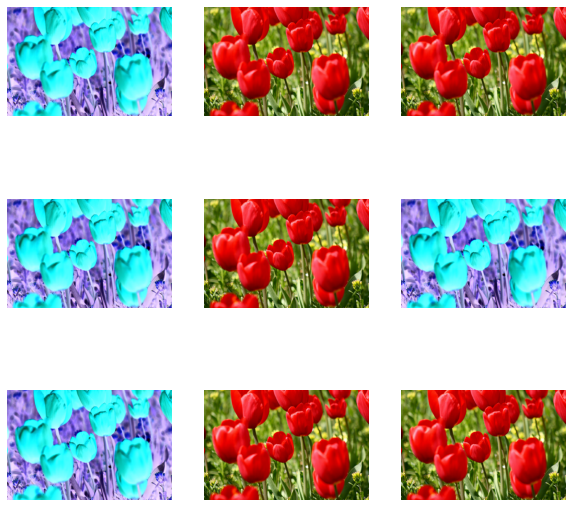

In [23]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

Next, implement a custom layer by [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models).

In [24]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

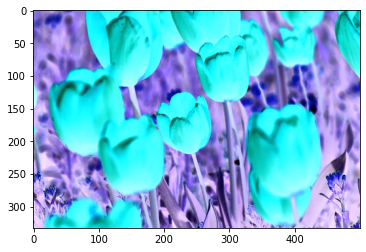

In [25]:
_ = plt.imshow(RandomInvert()(image)[0])

Both of these layers can be used as described in options 1 and 2 above.

## Using tf.image

The above `layers.preprocessing` utilities are convenient. For finer control, you can write your own data augmentation pipelines or layers using `tf.data` and `tf.image`. You may also want to check out [TensorFlow Addons Image: Operations](https://www.tensorflow.org/addons/tutorials/image_ops) and [TensorFlow I/O: Color Space Conversions](https://www.tensorflow.org/io/tutorials/colorspace)

Since the flowers dataset was previously configured with data augmentation, let's reimport it to start fresh.

In [26]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Retrieve an image to work with.

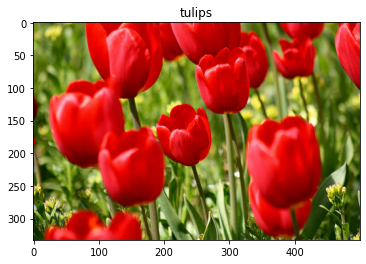

In [27]:
# Display data as an image and set a title for the axes.
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Let's use the following function to visualize and compare the original and augmented images side-by-side.

In [28]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### Data augmentation

### Flipping the image

Flip the image either vertically or horizontally.

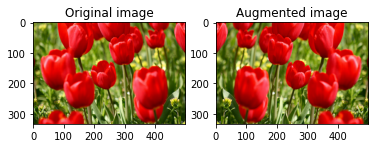

In [29]:
# Flip an image horizontally (left to right).
# TODO
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

### Grayscale the image

Grayscale an image.

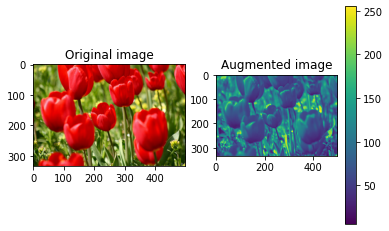

In [30]:
# Converts one or more images from RGB to Grayscale.
# TODO
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

### Saturate the image

Saturate an image by providing a saturation factor.

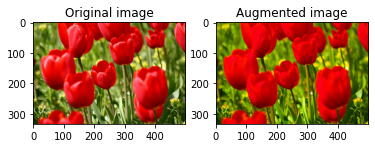

In [31]:
# Adjust saturation of RGB images.
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

### Change image brightness

Change the brightness of image by providing a brightness factor.

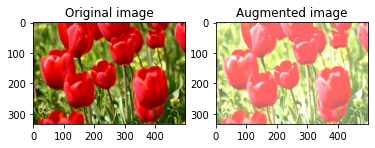

In [32]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

### Center crop the image

Crop the image from center up to the image part you desire.

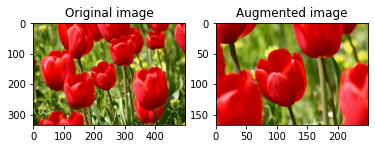

In [33]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

### Rotate the image

Rotate an image by 90 degrees.

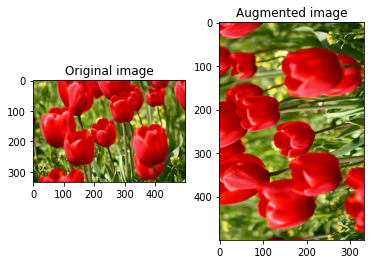

In [34]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

### Apply augmentation to a dataset

As before, apply data augmentation to a dataset using `Dataset.map`.

In [35]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [36]:
def augment(image,label):
  image, label = resize_and_rescale(image, label)
  # Add 6 pixels of padding
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
   # Random crop back to the original size
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.clip_by_value(image, 0, 1)
  return image, label

### Configure the datasets

In [37]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
) 

In [38]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [39]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

These datasets can now be used to train a model as shown previously.

## Next steps

This tutorial demonstrated data augmentation using [Keras Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/) and `tf.image`. To learn how to include preprocessing layers inside your model, see the [Image classification](https://www.tensorflow.org/tutorials/images/classification) tutorial. You may also be interested in learning how preprocessing layers can help you classify text, as shown in the [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) tutorial. You can learn more about `tf.data` in this [guide](https://www.tensorflow.org/guide/data), and you can learn how to configure your input pipelines for performance [here](https://www.tensorflow.org/guide/data_performance).

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License